In [160]:
#!/bin/python
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
import matplotlib.pyplot as plt

import ctcfgen
import sequence
import eval_TFmodel
import train_TFmodel
import numpy as np
import viz_sequence
import seq_only_gen
import helper
from matplotlib import cm

# get the generator
gen = seq_only_gen.TFGenerator('/home/kal/TF_models/seq_only/ctcfgen.hdf5')
g = gen.pos_gen()

In [2]:
seq = sequence.Sequence(next(g)[0])
sigmodel = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/20170919_sigmoid_model/')
pwm = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/')
regmodel = reg = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20180125_174348_CTCF/')
regmodel.model.predict(train_TFmodel.blank_batch(seq.seq))[0][0]

Loading model without Bias layer


616.2998

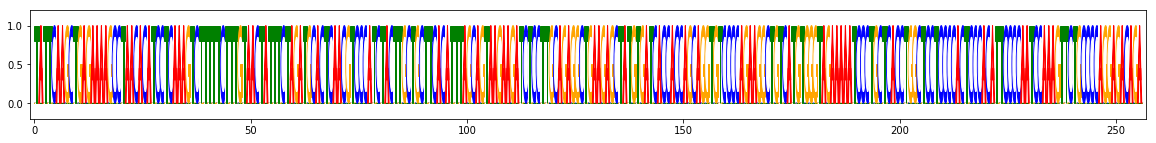

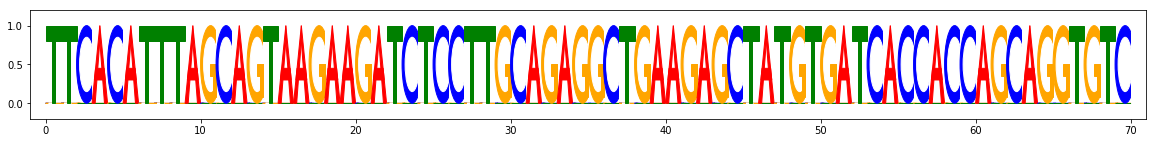

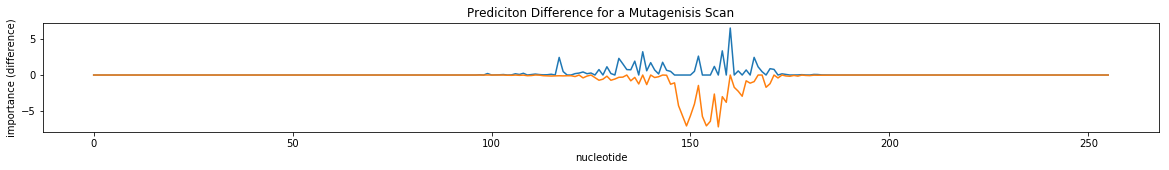

Masked average prediciton difference


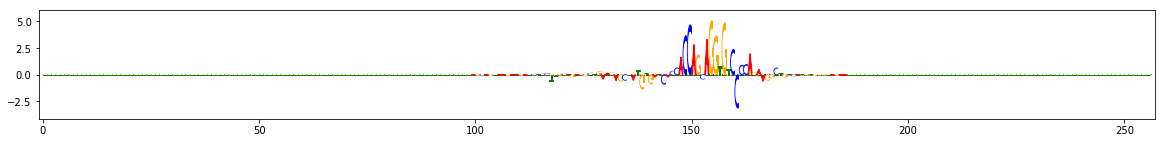

Information Content of Softmax prediction difference


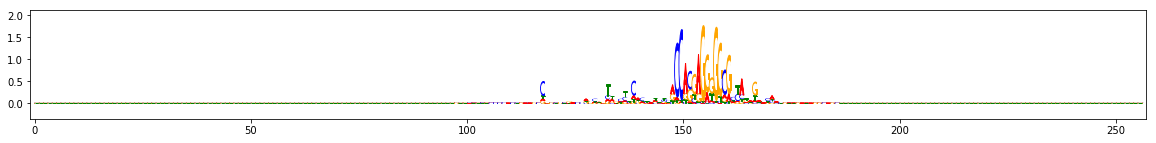

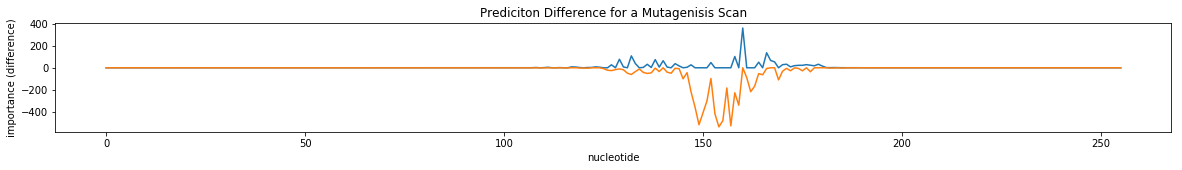

Masked average prediciton difference


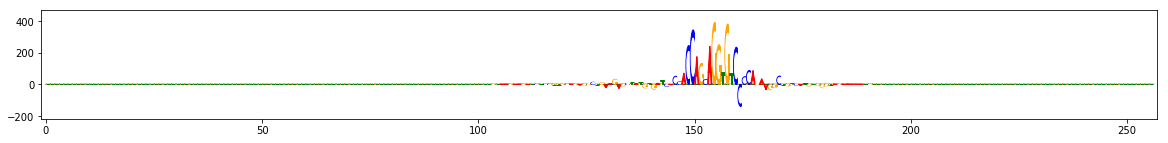

Information Content of Softmax prediction difference


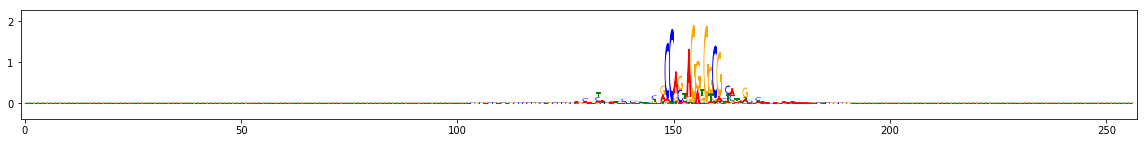

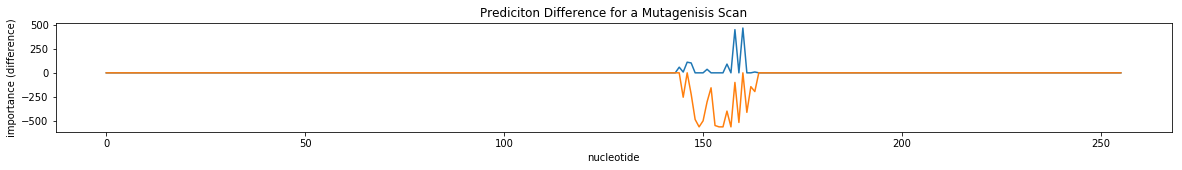

Masked average prediciton difference


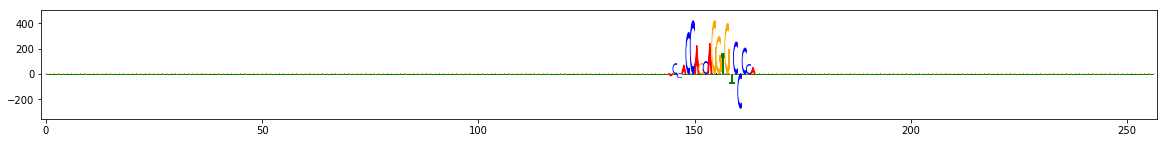

Information Content of Softmax prediction difference


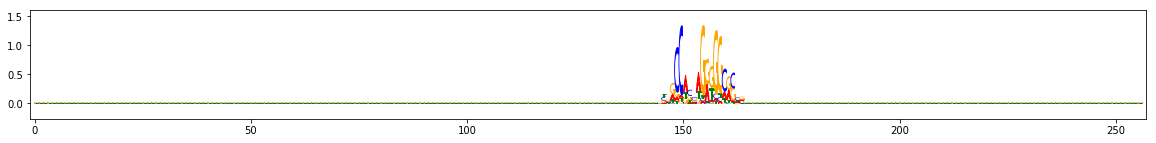

In [183]:
#print some stuff
seq.logo()
viz_sequence.plot_weights(seq.seq[90:160])
sigmodel.get_importance(seq, viz=True, plot=True, temp=.25)
importance = regmodel.get_importance(seq, viz=True, plot=True, temp=.15)
out = pwm.get_importance(seq, viz=True, plot=True, temp=.15)

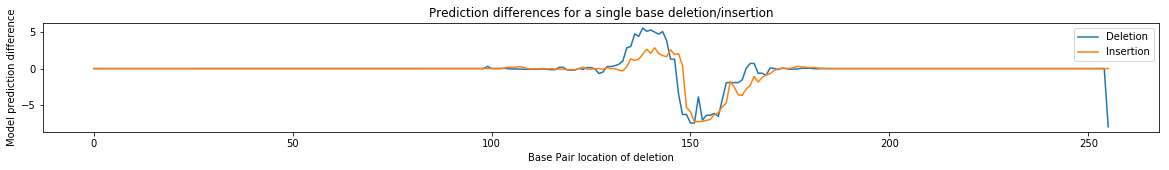

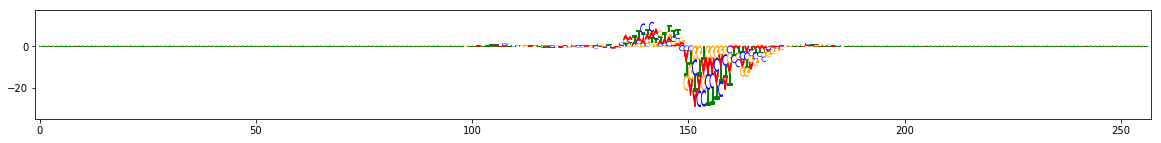

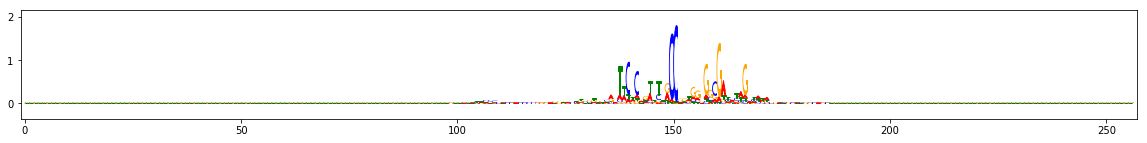

In [4]:
# look at deletion
deletes = sigmodel.get_activation(seq.deletion_mutant_gen()) - sigmodel.get_activation(seq)
additions = sigmodel.get_activation(seq.insertion_mutant_gen()) - sigmodel.get_activation(seq)
additions = additions.reshape(256,-1)

plt.figure(figsize=(20,2))
plt.plot(deletes)
plt.plot(np.average(additions, axis=1))
plt.title('Prediction differences for a single base deletion/insertion')
plt.ylabel('Model prediction difference')
plt.xlabel('Base Pair location of deletion')
plt.legend(['Deletion', 'Insertion'])
plt.show()

viz_sequence.plot_weights(additions)
viz_sequence.plot_icweights(helper.softmax(additions))


In [12]:
# double mutagenisis
doubles = sigmodel.get_activation(seq.double_mutant_gen()) - sigmodel.get_activation(seq)

In [157]:
doubles = doubles.reshape(256,4, -1, 4)
maxes = np.amax(doubles, axis=(3, 1))
mins = np.amin(doubles, axis=(1, 3))
nets = np.where(abs(maxes)>= abs(mins), maxes, mins)

# plot the maximum difference 
#im = plt.imshow(np.average(doubles, axis=(1,3)), cmap='plasma', vmin=-5, vmax=5)
#plt.colorbar(im)
#plt.title('Average Change for Double Mutagenisis of a Sequence')
#plt.ylabel('Location of Second Mutation')
#plt.xlabel('Location of First Mutation')
#plt.show()

# plot the maximum difference 
#im = plt.imshow(maxes, cmap='plasma', vmin=-5, vmax=5)
#plt.colorbar(im)
#plt.title('Gain for Double Mutagenisis of a Sequence')
#plt.ylabel('Location of Second Mutation')
#plt.xlabel('Location of First Mutation')
#plt.show()

# plot the minimum difference 
#im = plt.imshow(mins, cmap='plasma', vmin=-5, vmax=5)
#plt.colorbar(im)
#plt.title('Loss for Double Mutagenisis of a Sequence')
#plt.ylabel('Location of Second Mutation')
#plt.xlabel('Location of First Mutation')
#plt.show()


# plot the largest net difference 
#im = plt.imshow(nets, cmap='plasma', vmin=-5, vmax=5)
#plt.colorbar(im)
#plt.title('Change for Double Mutagenisis of a Sequence')
#plt.ylabel('Location of Second Mutation')
#plt.xlabel('Location of First Mutation')
#plt.show()

In [158]:
# normalize the change
norm1 = np.repeat(doubles.reshape(256, 4, -1)[:,:,0], (seq_len*4)).reshape((seq_len,4,seq_len,4))
norm2 = np.swapaxes(norm1, 0, 2)
norm2 = np.swapaxes(norm2, 1, 3)
normalizations = norm1 + norm2
maxes = np.amax(normalizations, axis=(3, 1))
mins = np.amin(normalizations, axis=(1, 3))
normnets = np.where(abs(maxes)>= abs(mins), maxes, mins)
print(normalizations.shape)

normdoubs = doubles - normalizations
nmaxes = np.amax(normdoubs, axis=(3, 1))
nmins = np.amin(normdoubs, axis=(1, 3))
nnets = np.where(abs(nmaxes)>= abs(nmins), nmaxes, nmins)

(256, 4, 256, 4)


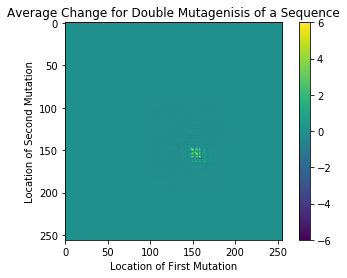

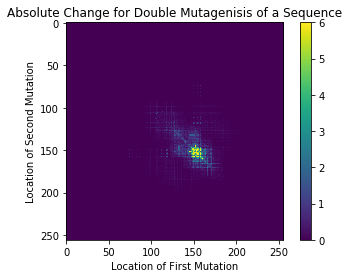

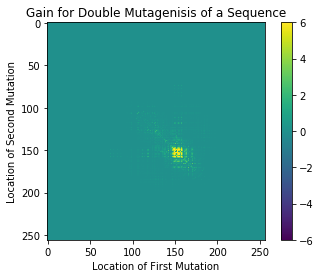

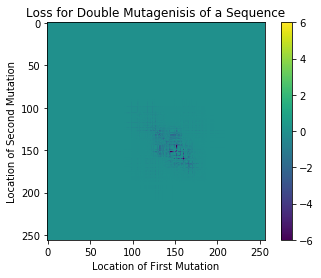

In [159]:
# plot the maximum difference 
im = plt.imshow(np.average(normdoubs, axis=(1,3)), vmin=-6, vmax=6)
plt.colorbar(im)
plt.title('Average Change for Double Mutagenisis of a Sequence')
plt.ylabel('Location of Second Mutation')
plt.xlabel('Location of First Mutation')
plt.show()


# plot the largest net difference 
im = plt.imshow(abs(nnets), vmin=0, vmax=6)
plt.colorbar(im)
plt.title('Absolute Change for Double Mutagenisis of a Sequence')
plt.ylabel('Location of Second Mutation')
plt.xlabel('Location of First Mutation')
plt.show()

# plot the maximum difference 
im = plt.imshow(nmaxes, vmin=-6, vmax=6)
plt.colorbar(im)
plt.title('Gain for Double Mutagenisis of a Sequence')
plt.ylabel('Location of Second Mutation')
plt.xlabel('Location of First Mutation')
plt.show()

# plot the minimum difference 
im = plt.imshow(nmins, vmin=-6, vmax=6)
plt.colorbar(im)
plt.title('Loss for Double Mutagenisis of a Sequence')
plt.ylabel('Location of Second Mutation')
plt.xlabel('Location of First Mutation')
plt.show()

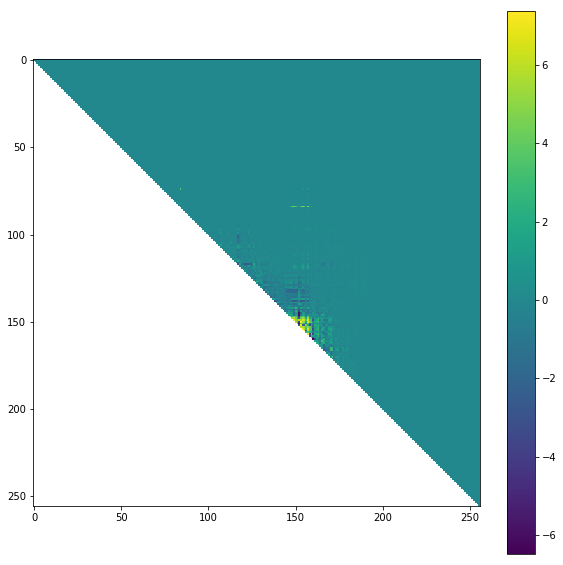

In [182]:
# as a contact frecquency
mask =  np.tri(nnets.shape[0], k=-1)
diag = np.ma.array(nnets, mask=mask) # mask out the lower triangle
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(111)
im = ax1.imshow(diag, interpolation="nearest")
fig.colorbar(im)

plt.show()